In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import canberra
import pymysql
import io, os, sys
import seaborn
import matplotlib.pyplot as plt

In [2]:
batch_sql = """
SELECT batch, cluster, npi, specialty_description, drug_name,
specialty_factor_drug FROM pa_kmeans_y_pred_spl_factor_drug WHERE drug_name = '{drug_name}' AND 
specialty_description = '{specialty_description}' AND npi = '{npi}';
"""

canberra_distance_sql = """
SELECT claim_per_dollar, supply_per_claim, drug_mean_claim_per_dollar, 
drug_mean_supply_per_claim, drug_std_claim_per_dollar,
drug_std_supply_per_claim, drug_weight, specialty_weight, bene_risk, 
IF(medicare_prvdr_enroll_status = 'E', 1, 0) as enroll_status, npi_claim_count,
pa_specialty_entropy.median_count,
IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
pa_cost_function.generic)))) as health_risk_ratio
FROM pa_cost_function
INNER JOIN claim_aggregates.pa_specialty_entropy ON 
pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
WHERE pa_cost_function.drug_name = '{drug_name}' AND 
pa_cost_function.specialty_description = '{specialty_description}' AND pa_cost_function.npi = '{npi}'
ORDER BY 
supply_per_claim, (drug_mean_supply_per_claim / drug_std_supply_per_claim),
(IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
pa_cost_function.generic)))));
"""

other_data_sql = """
SELECT pa_cost_function.specialty_description, pa_cost_function.drug_name, pa_cost_function.npi, 
pa_kmeans.cluster, pa_kmeans.batch,
claim_per_dollar, supply_per_claim, drug_mean_claim_per_dollar, 
drug_mean_supply_per_claim, drug_std_claim_per_dollar,
drug_std_supply_per_claim, drug_weight, specialty_weight, bene_risk, 
IF(medicare_prvdr_enroll_status = 'E', 1, 0) as enroll_status, npi_claim_count,
pa_specialty_entropy.median_count,
IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
pa_cost_function.generic)))) as health_risk_ratio
FROM pa_cost_function
INNER JOIN claim_aggregates.pa_specialty_entropy ON 
pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
INNER JOIN pa_kmeans_y_pred_spl_factor_drug pa_kmeans ON
pa_kmeans.specialty_description = pa_cost_function.specialty_description AND 
pa_kmeans.drug_name = pa_cost_function.drug_name AND 
pa_kmeans.npi = pa_cost_function.npi
WHERE pa_cost_function.drug_name = '{drug_name}' AND 
pa_cost_function.specialty_description = '{specialty_description}'
ORDER BY 
supply_per_claim, (drug_mean_supply_per_claim / drug_std_supply_per_claim),
(IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
pa_cost_function.generic)))));
"""

opt_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='optimization_tables')

cursor = opt_connection.cursor()
cursor.execute(batch_sql.format(drug_name='XOLAIR', specialty_description='Allergy/Immunology',
                npi='1851444269'))
batches_npi = cursor.fetchall()
cursor.close()
cursor = opt_connection.cursor()
cursor.execute(canberra_distance_sql.format(drug_name='XOLAIR', specialty_description='Allergy/Immunology',
                npi='1851444269'))
canberra_npi = cursor.fetchall()
cursor.close()
cursor = opt_connection.cursor()
cursor.execute(other_data_sql.format(drug_name='XOLAIR', specialty_description='Allergy/Immunology'))
other_npi_data = cursor.fetchall()
cursor.close()

print("There are : " + len(other_npi_data).__str__() + " data rows with this data")
print("The selected npi has " + len(canberra_npi).__str__() + " data row(s)")

There are : 27 data rows with this data
The selected npi has 1 data row(s)


In [3]:
print("The canberra distance for the same Domain records are: ")

batch = batches_npi[0][0]
cluster = batches_npi[0][1]

canberra_distance_array = []
for item in other_npi_data:
    canberra_distance_array.append(scipy.spatial.distance.canberra(list(canberra_npi[0]), list(item[5:])))

idx = 0
for item in other_npi_data:
    print("The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269', '{0}', '{1}') with: ".
         format(cluster, batch))
    print(" ('{drug_name}', '{specialty}', '{npi}', '{cluster}', '{batch}')".format(drug_name=item[1], specialty=item[0],
           npi=item[2], batch=item[4], cluster=item[3]))
    print(" is: " + canberra_distance_array[idx].__str__() + "\n")
    idx = idx + 1

The canberra distance for the same Domain records are: 
The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269', '34', '3') with: 
 ('XOLAIR', 'Allergy/Immunology', '1851444269', '34', '3')
 is: 0.0

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269', '34', '3') with: 
 ('XOLAIR', 'Allergy/Immunology', '1922056530', '34', '3')
 is: 1.54581733978

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269', '34', '3') with: 
 ('XOLAIR', 'Allergy/Immunology', '1598974560', '34', '3')
 is: 1.13003863111

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269', '34', '3') with: 
 ('XOLAIR', 'Allergy/Immunology', '1114981610', '34', '3')
 is: 1.20815764387

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269', '34', '3') with: 
 ('XOLAIR', 'Allergy/Immunology', '1376619387', '34', '3')
 is: 1.19269852723

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '18

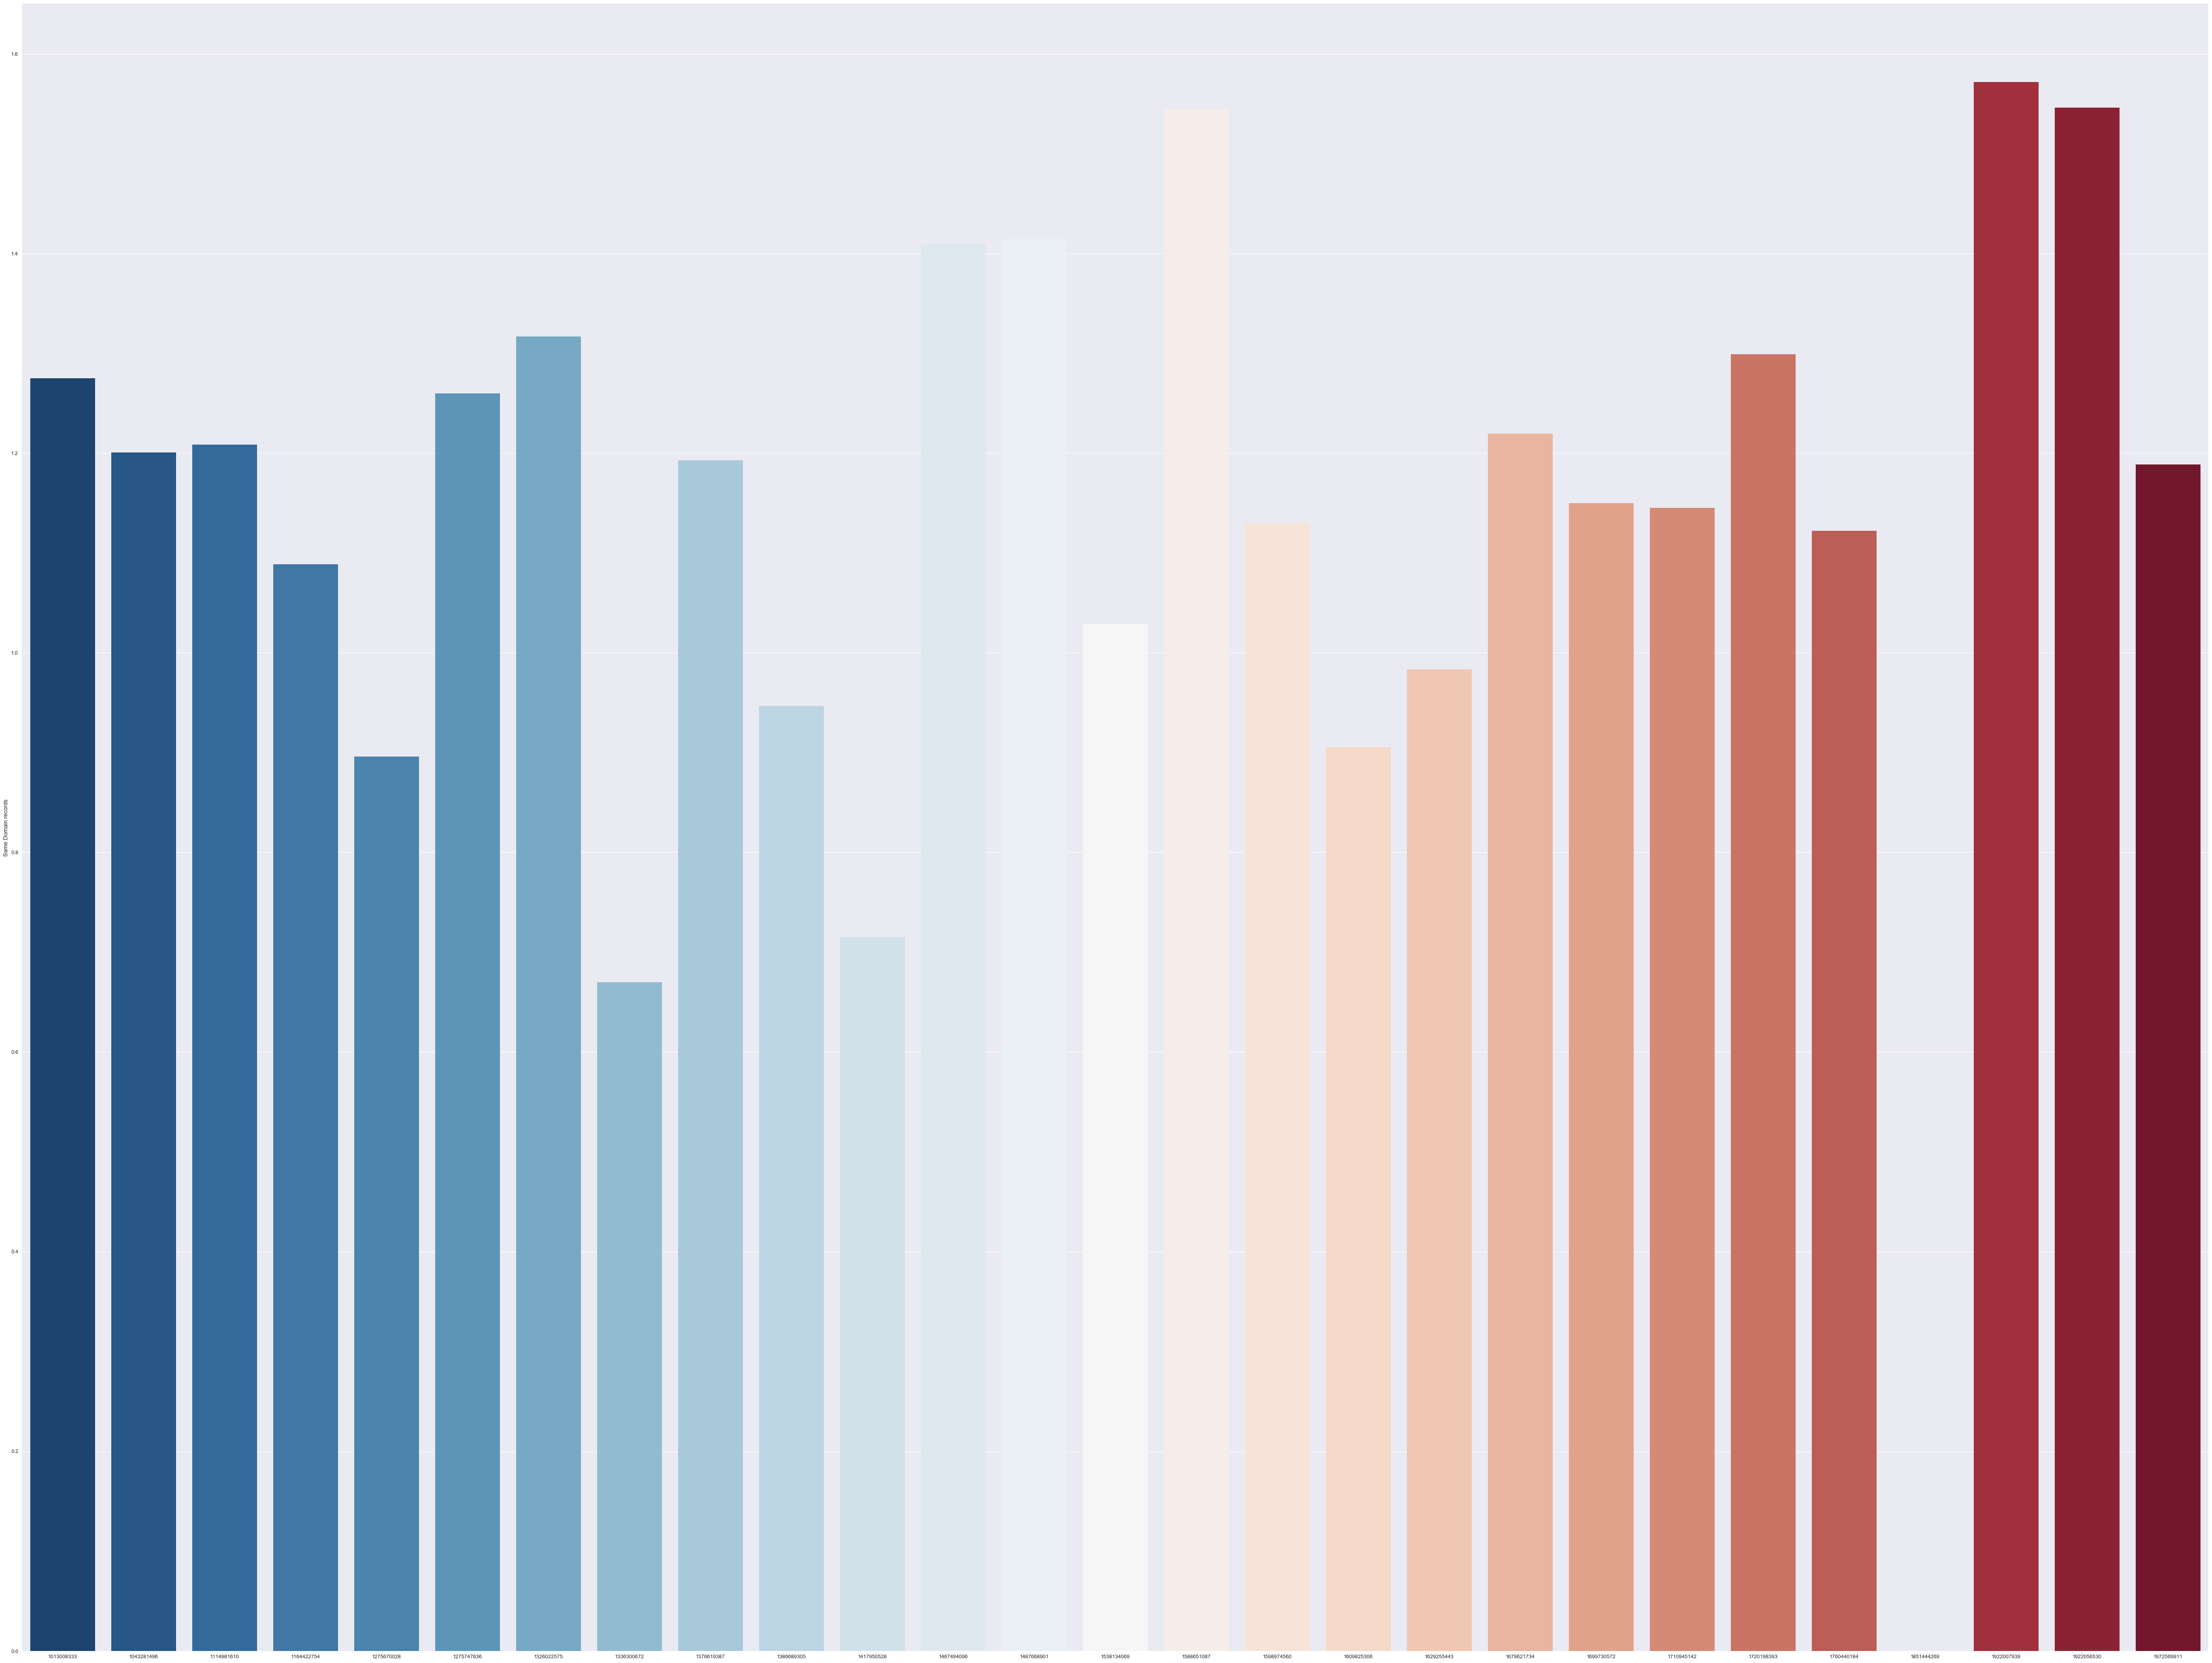

In [11]:
x = []
y = []
idx = 0
for item in other_npi_data:
    x.append(item[2])
    y.append(canberra_distance_array[idx])
    idx = idx + 1

f, (ax3) = plt.subplots(1, 1, figsize=(75, 58), sharex=True)

seaborn.barplot(x, y, palette="RdBu_r", ax=ax3)
ax3.set_ylabel("Same Domain records")

In [21]:
print("The canberra distance with the same Cluster Batch records are: ")

cluster_batch_data_sql = """
SELECT pa_cost_function.specialty_description, pa_cost_function.drug_name, pa_cost_function.npi, 
claim_per_dollar, supply_per_claim, drug_mean_claim_per_dollar, 
drug_mean_supply_per_claim, drug_std_claim_per_dollar,
drug_std_supply_per_claim, drug_weight, specialty_weight, bene_risk, 
IF(medicare_prvdr_enroll_status = 'E', 1, 0) as enroll_status, npi_claim_count,
pa_specialty_entropy.median_count,
IF(drug_state_category = 'opioid', pa_cost_function.opioid, 
IF(drug_state_category = 'antibiotic', pa_cost_function.antibiotic, 
IF(drug_state_category = 'antipsychotic', pa_cost_function.antipsychotic, 
IF(drug_state_category = 'HRM', pa_cost_function.hrm, 
pa_cost_function.generic)))) as health_risk_ratio
FROM pa_cost_function
INNER JOIN claim_aggregates.pa_specialty_entropy ON 
pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
INNER JOIN pa_kmeans_y_pred_spl_factor_drug pa_kmeans ON
pa_kmeans.specialty_description = pa_cost_function.specialty_description
AND pa_kmeans.drug_name = pa_cost_function.drug_name
AND pa_kmeans.npi = pa_cost_function.npi
WHERE pa_kmeans.cluster = '{cluster}' AND 
pa_kmeans.batch = '{batch}'
"""

cursor = opt_connection.cursor()
cursor.execute(cluster_batch_data_sql.format(cluster=cluster, batch=batch))
cluster_batch_data = cursor.fetchall()
cursor.close()

canberra_cluster = []
for item in cluster_batch_data:
    canberra_cluster.append(scipy.spatial.distance.canberra(canberra_npi, item[3:]))

The canberra distance with the same Cluster Batch records are: 
The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('METHADONE HCL', 'Pain Management', '1558354738')
 is: 3.82868805225

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('PREDNISONE', 'Medical Oncology', '1952303471')
 is: 3.58484755429

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('DIVALPROEX SODIUM', 'Neuropsychiatry', '1760559900')
 is: 4.89854017982

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('CARAFATE', 'Thoracic Surgery', '1700850666')
 is: 4.34645333951

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('REVLIMID', 'Medical Oncology', '1205800794')
 is: 2.13475876258

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('TRAMADOL HCL', 'Interventional Pain Management', '1245243

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('HYDROMORPHONE HCL', 'Interventional Pain Management', '1114185402')
 is: 4.54214147844

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('HYDROMORPHONE HCL', 'Interventional Pain Management', '1114185402')
 is: 4.54214147844

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('HYDROMORPHONE HCL', 'Interventional Pain Management', '1114185402')
 is: 4.54214147844

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('HYDROMORPHONE HCL', 'Interventional Pain Management', '1114185402')
 is: 4.54214147844

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('PATADAY', 'Pediatric Medicine', '1972504165')
 is: 3.24889609804

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('SPIRIVA', 'Pathology', '1518996743')
 is: 

 ('INVEGA SUSTENNA', 'Neuropsychiatry', '1942294111')
 is: 4.06830708908

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('VOLTAREN', 'Sports Medicine', '1659433019')
 is: 4.46140612787

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('GLEEVEC', 'Medical Oncology', '1063486603')
 is: 2.74991040338

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('CYCLOBENZAPRINE HCL', 'Anesthesiology', '1073943759')
 is: 5.03083162586

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('TRAMADOL HCL', 'Neurological Surgery', '1881652733')
 is: 6.97620390931

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('METHOCARBAMOL', 'Anesthesiology', '1699985044')
 is: 5.2777893753

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('CELECOXIB', 'Anesthesiology', '1184660474')


The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('MORPHINE SULFATE ER', 'Pain Management', '1902049695')
 is: 3.92011628189

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('DIVALPROEX SODIUM', 'Neuropsychiatry', '1295762003')
 is: 3.95266269601

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('VENTOLIN HFA', 'Allergy/Immunology', '1164427480')
 is: 2.70297385344

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('MORPHINE SULFATE ER', 'Anesthesiology', '1750481461')
 is: 3.75959597417

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('HYDROCODONE-ACETAMINOPHEN', 'Anesthesiology', '1750543476')
 is: 4.99536696771

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('TRAMADOL HCL', 'Pain Management', '1871686592')
 is: 4.93202542066

The distance metric

 ('NIACIN ER', 'Pediatric Medicine', '1033187646')
 is: 4.20062159288

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('CYCLOBENZAPRINE HCL', 'Anesthesiology', '1013960277')
 is: 5.02025343643

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('ZETIA', 'Cardiac Electrophysiology', '1932102878')
 is: 3.47148146756

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('MELOXICAM', 'Interventional Pain Management', '1558361790')
 is: 3.53506305636

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('ZOLPIDEM TARTRATE', 'Interventional Pain Management', '1366555104')
 is: 5.06065457611

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('HYDROCODONE-ACETAMINOPHEN', 'Pain Management', '1457522070')
 is: 5.1342108108

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('BACLOFEN', 'Anesthesiology', '1225187586')
 is: 3.43085205602

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('MORPHINE SULFATE ER', 'Anesthesiology', '1225187586')
 is: 3.67330142516

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('MORPHINE SULFATE ER', 'Anesthesiology', '1679789010')
 is: 3.37039731097

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('OXYMORPHONE HCL', 'Anesthesiology', '1578661070')
 is: 3.5907977783

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('CARVEDILOL', 'Pediatric Medicine', '1598728719')
 is: 4.46914767509

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('GABAPENTIN', 'Addiction Medicine', '1972728145')
 is: 5.01386630803

The distance metric in comparing ('XOLAIR'


The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('BUDESONIDE', 'Allergy/Immunology', '1790872489')
 is: 3.28973193153

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('BUDESONIDE', 'Critical Care (Intensivists)', '1437119211')
 is: 4.36284546575

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('DISOPYRAMIDE PHOSPHATE', 'Cardiac Electrophysiology', '1184697914')
 is: 5.23325636593

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('TAMOXIFEN CITRATE', 'Medical Oncology', '1699949040')
 is: 3.577823423

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('TAMOXIFEN CITRATE', 'Medical Oncology', '1518971852')
 is: 3.67145773849

The distance metric in comparing ('XOLAIR', 'Allergy/Immunology', '1851444269') with: 
 ('BETAMETHASONE DIPROPIONATE', 'Pain Management', '1235347840')
 is: 4.83112335

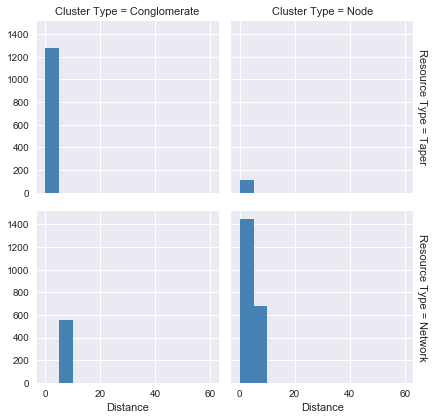

In [23]:
x_1 = []
x_2 = []
x_3 = []
x_4 = []
y = []
df = pd.DataFrame(columns=['Resource Type', 'Cluster Type', 'Distance'])
idx = 0
for item in cluster_batch_data:
    if canberra_cluster[idx] >= 5.70:
        df = df.append({'Resource Type': 'Network', 'Cluster Type': 'Conglomerate', 'Distance': canberra_cluster[idx]},
                      ignore_index=True)
    elif canberra_cluster[idx] < 5.70 and canberra_cluster[idx] >= 4.00:
        df = df.append({
            'Resource Type': 'Network', 'Cluster Type': 'Node', 'Distance': canberra_cluster[idx]
        }, ignore_index=True)
    elif canberra_cluster[idx] < 4.00 and canberra_cluster[idx] >= 2.40:
        df = df.append({
            'Resource Type': 'Taper', 'Cluster Type': 'Conglomerate', 'Distance': canberra_cluster[idx]
        }, ignore_index=True)
    else:
        df = df.append({
            'Resource Type': 'Taper', 'Cluster Type': 'Node', 'Distance': canberra_cluster[idx]
        }, ignore_index=True)
    
    idx = idx + 1
    
seaborn.set(style="darkgrid")
g = seaborn.FacetGrid(df, row="Resource Type", col="Cluster Type", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "Distance", color="steelblue", bins=bins, lw=0)